# Get the Data

In [1]:
import os

In [2]:
def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        return f.read()

In [3]:
source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = load_data(source_path)
target_text = load_data(target_path)

# Explore the Data

In [4]:
import numpy as np

In [5]:
en_sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in en_sentences]

print('Number of English unique words: \t\t{}'.format(len({word: None for word in source_text.split()})))
print('Number of English sentences: \t\t\t{}'.format(len(en_sentences)))
print('Average number of words in a sentence: \t\t{:f}'.format(np.average(word_counts)))

Number of English unique words: 		227
Number of English sentences: 			137861
Average number of words in a sentence: 		13.225278


In [6]:
view_sentence_range = (0, 10)

print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .


In [7]:
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
california est généralement calme en mars , et il est généralement chaud en juin .
les états-unis est parfois légère en juin , et il fait froid en septembre .
votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .
son fruit préféré est l'orange , mais mon préféré est le raisin .
paris est relaxant en décembre , mais il est généralement froid en juillet .
new jersey est occupé au printemps , et il est jamais chaude en mars .
notre fruit est moins aimé le citron , mais mon moins aimé est le raisin .
les états-unis est parfois occupé en janvier , et il est parfois chaud en novembre .


# Data Preprocessing

## Build Vocabulary

In [8]:
from collections import Counter

In [9]:
def get_vocab(text):
    vocab_counts = Counter(w for t in text for w in t.split())
    vocab = sorted(vocab_counts, key=vocab_counts.get, reverse=True)
    return vocab, vocab_counts

In [10]:
fr_sentences = target_text.split('\n')
en_vocab, en_vocab_counts = get_vocab(en_sentences)
fr_vocab, fr_vocab_counts = get_vocab(fr_sentences)

In [11]:
len(en_sentences)

137861

In [12]:
print(fr_vocab[:50])
print(len(fr_vocab))

['est', '.', ',', 'en', 'il', 'les', 'mais', 'et', 'la', 'parfois', 'jamais', 'le', "l'", 'généralement', 'moins', 'au', 'aimé', 'fruit', 'préféré', 'agréable', 'froid', 'son', 'chaud', 'de', 'plus', 'automne', 'mois', 'à', 'elle', 'citrons', 'paris', 'inde', 'états-unis', 'france', 'jersey', 'new', 'chine', 'pendant', 'pamplemousse', 'mon', 'votre', 'juin', 'printemps', 'janvier', 'hiver', 'mars', 'été', 'mai', 'septembre', 'juillet']
355


## Index Words

In [13]:
pad = 0
eos = 1
unk = 2
go = 3

In [14]:
def get_idx(vocab, vocab_counts):
    word2index = {w: i+4 for i, w in enumerate(vocab)}
    word2index['<PAD>'] = pad
    word2index['<EOS>'] = eos
    word2index['<UNK>'] = unk
    word2index['<GO>'] = go
    
    index2word = {i: w for w, i in word2index.items()}
    
    return word2index, index2word

In [15]:
en_word2index, en_index2word = get_idx(en_vocab, en_vocab_counts)
fr_word2index, fr_index2word = get_idx(fr_vocab, fr_vocab_counts)

In [16]:
source_id = [[en_word2index[w] for w in s.split()] for s in en_sentences]
target_id = [[fr_word2index[w] for w in s.split()+['<EOS>']] for s in fr_sentences]

In [17]:
import pickle

In [18]:
with open('data/id.pkl', 'wb') as fp:
    pickle.dump((en_word2index, en_index2word,
                 fr_word2index, fr_index2word,
                 source_id, target_id), fp, -1)

## Checkpoint

In [19]:
import pickle

In [20]:
with open('data/id.pkl', 'rb') as fp:
    en_word2index, en_index2word, fr_word2index, fr_index2word, source_id, target_id = pickle.load(fp)

## Build Datasets

In [21]:
from keras.preprocessing import sequence
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [22]:
sequence_length = max([len(s) for s in source_id+target_id])
MAX_LEN = sequence_length
EN_VOCAB_SIZE = len(en_word2index)
FR_VOCAB_SIZE = len(fr_word2index)
pad = 0
eos = 1
unk = 2
go = 3

In [23]:
def convert_seq(source_id, target_id):
    new_source_id = sequence.pad_sequences(source_id, maxlen=MAX_LEN, value=pad,
                                           padding='post')
    new_target_id = sequence.pad_sequences(target_id, maxlen=MAX_LEN, value=pad,
                                           padding='post')
    
    target_id_label = np.zeros((len(new_target_id), MAX_LEN, FR_VOCAB_SIZE))
    for i, t in enumerate(new_target_id):
        target_id_label[i, :, :] = np_utils.to_categorical(t, FR_VOCAB_SIZE)
        
    new_target_id = sequence.pad_sequences(new_target_id, maxlen=MAX_LEN+1, value=go,
                                           padding='pre')
    new_target_id = sequence.pad_sequences(new_target_id, maxlen=MAX_LEN, truncating='post')
    
    
    return new_source_id, new_target_id, target_id_label

In [24]:
en_X, fr_X, Y = convert_seq(source_id, target_id)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = np.column_stack((en_X, fr_X))
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
en_Xtrain = Xtrain[:, :24]
fr_Xtrain = Xtrain[:, 24:]
en_Xval = Xval[:, :24]
fr_Xval = Xval[:, 24:]

# Build Model

## Set Hyperparameters

In [28]:
NUM_EPOCHS = 32
BATCH_SIZE = 64
RNN_SIZE = 128
RNN_LAYERS = 2
ENCODING_EMBEDDING_SIZE = 50
DECODING_EMBEDDING_SIZE = 50
LEARNING_RATE = 0.02
DROPOUT_RATE = 0.2

## Build Graph

In [29]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout, RepeatVector, Dense
from keras.layers.recurrent import LSTM
from keras.layers.merge import concatenate
from keras.layers.wrappers import TimeDistributed
from keras.models import Model

### Encoder

In [30]:
en_input = Input(shape=(MAX_LEN,), dtype='int32', name='en_input')
enc_en = Embedding(input_dim=EN_VOCAB_SIZE, output_dim=ENCODING_EMBEDDING_SIZE, 
                   input_length=MAX_LEN, name='en_emb')(en_input)
enc_en = Dropout(DROPOUT_RATE)(enc_en)
if RNN_LAYERS == 1:
    enc_en = LSTM(RNN_SIZE, name='enc_lstm_1')(enc_en)
else:    
    for i in range(RNN_LAYERS-1):
        enc_en = LSTM(RNN_SIZE, return_sequences=True, name='enc_lstm_%d'%(i+1))(enc_en)
        enc_en = Dropout(DROPOUT_RATE)(enc_en)
    enc_en = LSTM(RNN_SIZE, name='enc_lstm_3')(enc_en)

### Context

In [31]:
context = RepeatVector(MAX_LEN, name='context')(enc_en)

### Decoder

In [32]:
fr_input = Input(shape=(MAX_LEN,), dtype='int32', name='fr_input')
dec_fr = Embedding(input_dim=FR_VOCAB_SIZE, output_dim=DECODING_EMBEDDING_SIZE,
                   input_length=MAX_LEN, name='fr_emb')(fr_input)
dec_fr = Dropout(DROPOUT_RATE)(dec_fr)
dec_fr = concatenate([context, dec_fr], axis=-1)
for i in range(RNN_LAYERS):
    dec_fr = LSTM(RNN_SIZE, return_sequences=True, name='dec_lstm_%d'%(i+1))(dec_fr)
    dec_fr = Dropout(DROPOUT_RATE)(dec_fr)
dec_fr = TimeDistributed(Dense(FR_VOCAB_SIZE, activation='softmax', name='softmax'))(dec_fr)

### Compile

In [33]:
model = Model(inputs=[en_input, fr_input], outputs=dec_fr)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Visualization

In [34]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

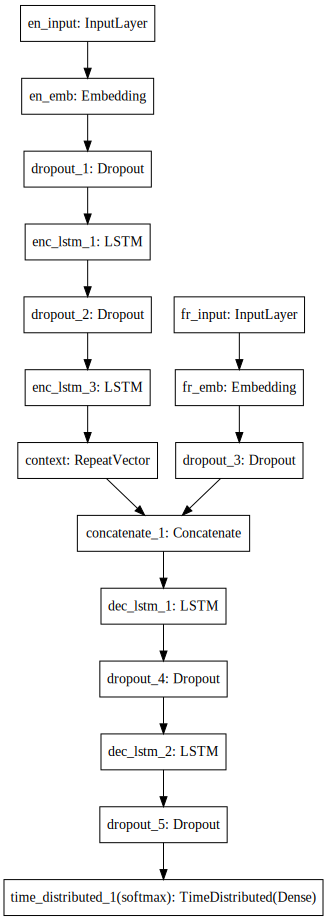

In [35]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
en_input (InputLayer)            (None, 24)            0                                            
____________________________________________________________________________________________________
en_emb (Embedding)               (None, 24, 50)        11550       en_input[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 24, 50)        0           en_emb[0][0]                     
____________________________________________________________________________________________________
enc_lstm_1 (LSTM)                (None, 24, 128)       91648       dropout_1[0][0]                  
___________________________________________________________________________________________

# Train

In [19]:
# from keras.callbacks import TensorBoard

In [20]:
# 在当前目录新建logs文件夹，记录 evens.out
# tb = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=Flase, write_images=True
#                  embeddings_freq=1) 

In [21]:
# history = model.fit([en_Xtrain, fr_Xtrain], Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
#                     validation_data=([en_Xval, fr_Xval], Yval), callbacks=[tb])

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [23]:
filepath = 'data/checkpoint/weights.{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', verbose=1, patience=3)
rlr = ReduceLROnPlateau(monitor='val_acc', verbose=1, factor=0.5, patience=1)

In [24]:
history = model.fit([en_Xtrain, fr_Xtrain], [Ytrain], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_data=([en_Xval, fr_Xval], [Yval]), callbacks=[checkpoint, es, rlr])

Train on 110288 samples, validate on 27573 samples
Epoch 1/32
110288/110288 [==============================] - 1306s - loss: 1.4079 - acc: 0.6529 - val_loss: 0.7353 - val_acc: 0.7572
Epoch 2/32
110288/110288 [==============================] - 1317s - loss: 0.6558 - acc: 0.7755 - val_loss: 0.5272 - val_acc: 0.8054
Epoch 3/32
110288/110288 [==============================] - 1290s - loss: 0.4816 - acc: 0.8235 - val_loss: 0.3857 - val_acc: 0.8573
Epoch 4/32
110288/110288 [==============================] - 1242s - loss: 0.3817 - acc: 0.8567 - val_loss: 0.3220 - val_acc: 0.8728
Epoch 5/32
110288/110288 [==============================] - 1216s - loss: 0.3255 - acc: 0.8728 - val_loss: 0.2632 - val_acc: 0.8954
Epoch 6/32
110288/110288 [==============================] - 1180s - loss: 0.2755 - acc: 0.8895 - val_loss: 0.2121 - val_acc: 0.9105
Epoch 7/32
110288/110288 [==============================] - 1173s - loss: 0.2271 - acc: 0.9048 - val_loss: 0.1710 - val_acc: 0.9261
Epoch 8/32
110288/110288 

110288/110288 [==============================] - 1167s - loss: 0.0538 - acc: 0.9746 - val_loss: 0.0415 - val_acc: 0.9787
Epoch 27/32
110288/110288 [==============================] - 1168s - loss: 0.0514 - acc: 0.9759 - val_loss: 0.0375 - val_acc: 0.9814
Epoch 28/32
110288/110288 [==============================] - 1169s - loss: 0.0481 - acc: 0.9778 - val_loss: 0.0373 - val_acc: 0.9813
Epoch 29/32
110288/110288 [==============================] - 1168s - loss: 0.0462 - acc: 0.9784 - val_loss: 0.0352 - val_acc: 0.9818
Epoch 30/32
110288/110288 [==============================] - 1169s - loss: 0.0452 - acc: 0.9786 - val_loss: 0.0345 - val_acc: 0.9821
Epoch 31/32
110288/110288 [==============================] - 1169s - loss: 0.0440 - acc: 0.9790 - val_loss: 0.0338 - val_acc: 0.9825
Epoch 32/32
110288/110288 [==============================] - 1169s - loss: 0.0429 - acc: 0.9795 - val_loss: 0.0333 - val_acc: 0.9824


# Prediction